In [1]:
%matplotlib inline

In [76]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import scipy.sparse as sp
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from gae.preprocessing import mask_test_edges
from mycelium.datasets import load_protein, load_dataset, load_split, read_r_data
from mycelium.utils.base import sparse_to_tuple, mask_from_indices_like, apply_mask

In [77]:
plt.style.use('seaborn-colorblind')

plt.rc('text', usetex=True)
# plt.rc('font', family='serif', serif=['Lato']) #, size=16)
# plt.rc('animation', convert_path='/usr/bin/convert')

np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [78]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

In [79]:
SEED = 8888

# latent dimension
K = 3
EVERY_STEPS = 100
NUM_EPOCHS = 2000

In [80]:
sess = tf.InteractiveSession()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [81]:
G = read_r_data(name="Y_Pro", path="../datasets/protein/Y_Pro.rda")

The graph has N nodes and M edges:

In [82]:
N = G.number_of_nodes()
N

230

In [83]:
M = G.number_of_edges()
M

695

The maximal number of edges is $N (N-1) / 2$:

In [84]:
C = N*(N-1)//2
C

26335

The density of the graph is:

In [85]:
M / C

0.026390734763622557

In [86]:
# can also do this
nx.density(G)

0.026390734763622557

### Graph Visualization

In [87]:
pos = nx.spring_layout(G, k=0.8, seed=SEED)

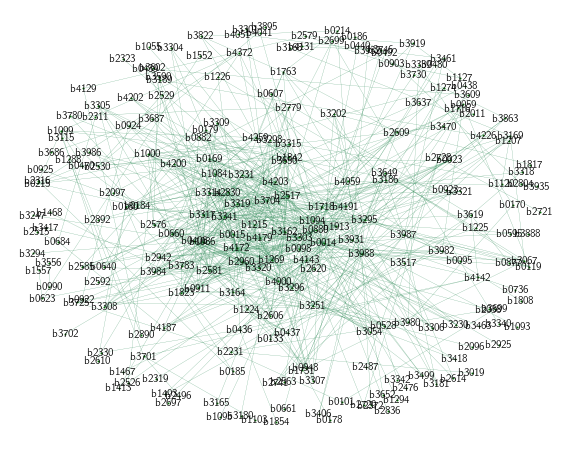

In [88]:
fig, ax = plt.subplots(figsize=(10, 8))

nx.draw(G, pos=pos, with_labels=True, node_size=1, node_color="darkgreen",
        font_size=11, font_weight="bold", edge_color="seagreen", 
        width=0.2, alpha=0.9, ax=ax)

# plt.show()
plt.savefig("featured.png")

In [91]:
?nx.to_scipy_sparse_matrix

In [184]:
adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(nx.to_scipy_sparse_matrix(G))

/usr/local/lib/python3.5/dist-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [102]:
import scipy.sparse as sps

In [110]:
A = sps.csr_matrix((np.ones(len(train_edges)), tuple(train_edges.T)), shape=adj_train.shape)
A

<230x230 sparse matrix of type '<class 'numpy.float64'>'
	with 592 stored elements in Compressed Sparse Row format>

In [101]:
train_edges

array([[  0,  91],
       [  0, 167],
       [  0, 225],
       ...,
       [207, 212],
       [213, 221],
       [226, 227]], dtype=int32)

In [97]:
adj_train

<230x230 sparse matrix of type '<class 'numpy.float64'>'
	with 1184 stored elements in Compressed Sparse Row format>

In [119]:
A

<230x230 sparse matrix of type '<class 'numpy.float64'>'
	with 592 stored elements in Compressed Sparse Row format>

### Adjacency Matrix Visualization

In [139]:
A_df = nx.to_pandas_adjacency(G, dtype=np.uint32)

/usr/local/lib/python3.5/dist-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Load the $N \times N$ adjacency matrix.

In [140]:
A = nx.to_numpy_array(G)
A.shape

(230, 230)

In [180]:
A[tuple(test_edges.T)]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [186]:
A[tuple(np.asarray(test_edges_false).T)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
test_edges_false

In [181]:
A[tuple(test_edges_false.T)]

AttributeError: 'list' object has no attribute 'T'

In [143]:
adj = sps.csr_matrix((np.hstack((np.ones(len(test_edges)), np.zeros(len(test_edges_false)))), 
                      tuple(np.vstack((test_edges, test_edges_false)).T)), 
                     shape=adj_train.shape)
adj

<230x230 sparse matrix of type '<class 'numpy.float64'>'
	with 138 stored elements in Compressed Sparse Row format>

In [147]:
m = ~mask_from_indices_like(tuple(np.vstack((test_edges, test_edges_false)).T), A)
m

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

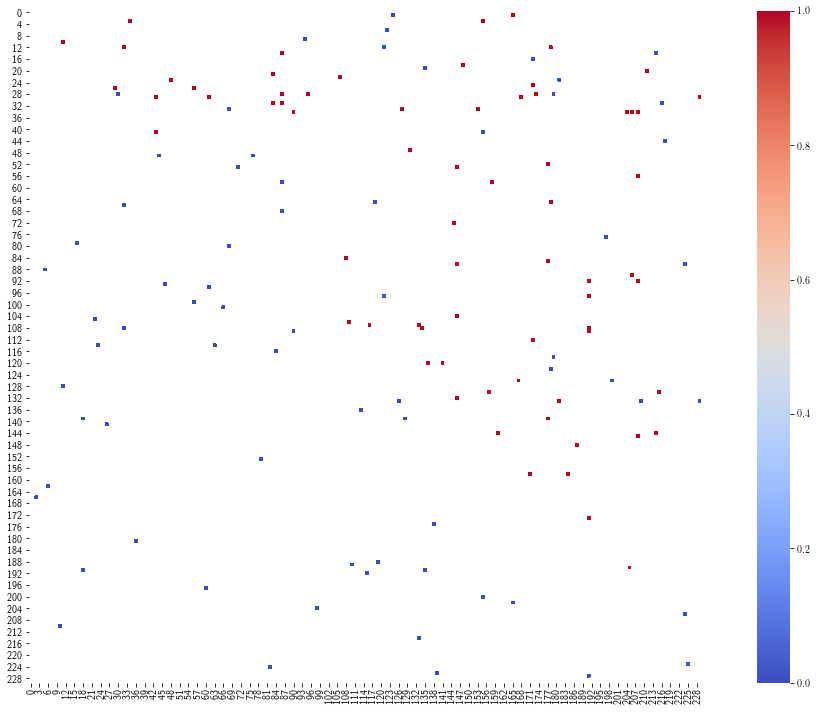

In [171]:
fig, ax = plt.subplots(figsize=golden_size(20))

sns.heatmap(adj.toarray(), mask=m, square=True, cmap="coolwarm", ax=ax)

plt.show()

In [17]:
np.all(A.T == A)

True

In [18]:
np.all(A.diagonal() == 0)

True

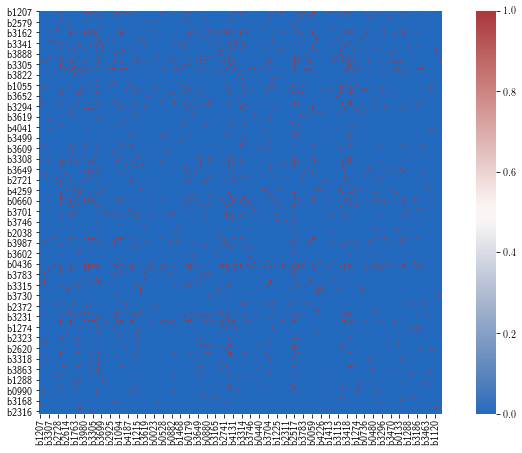

In [19]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(A_df, square=True, cmap="vlag", ax=ax)

plt.show()

### Lower-triangular Entries

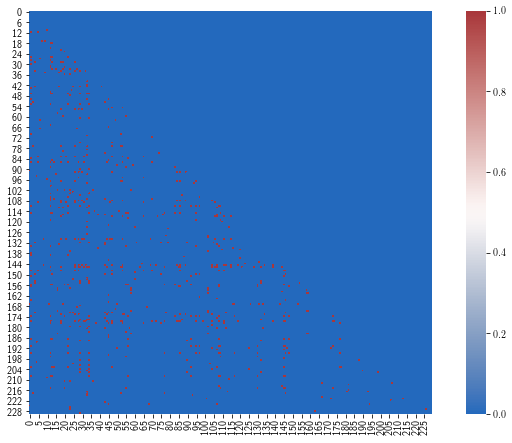

In [20]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(np.tril(A, k=-1), square=True, cmap="vlag", ax=ax)

plt.show()

### Lower-triangular Entries (Masking)

In the previous plot, we have simply zero'ed everything beyond the lower-triangular entries. However, there is nothing to distinquish irrelevant entries from negative labels, which are also zero-valued.

In [21]:
il = np.tril_indices_from(A, k=-1)
il

(array([  1,   2,   2, ..., 229, 229, 229]),
 array([  0,   0,   1, ..., 226, 227, 228]))

Now *all* of the datapoints are shown below. Only the colored values are relevant, where blue is negative (0), while red is positive (1).

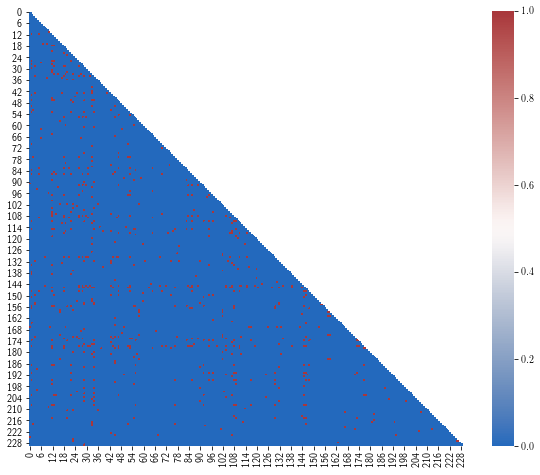

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(A, mask=~mask_from_indices_like(il, A), square=True, cmap="vlag", ax=ax)

# plt.show()
plt.savefig("masked_adjacency_lower.png")

In total, there are $N (N-1) / 2$ datapoints:

In [23]:
len(A[il])

26335

### Stratified Train-test Split

In [24]:
[il_train_i, il_test_i, 
 il_train_j, il_test_j] = train_test_split(*il, test_size=0.15, stratify=A[il], random_state=SEED)

In [25]:
il_train = (il_train_i, il_train_j)
il_train

(array([159, 155, 118, ..., 198, 101, 152]),
 array([96, 82, 66, ..., 77,  5,  8]))

In [26]:
il_test = (il_test_i, il_test_j)
il_test

(array([149, 166,  34, ...,  33, 156, 136]),
 array([ 75,  18,  27, ...,  17, 108,  62]))

#### Train-test Proportion

Verify that the specified train-test proportion has been satisfied:

In [27]:
len(A[il_train])

22384

In [28]:
len(A[il_test])

3951

In [29]:
len(A[il_test]) / (len(A[il_train]) + len(A[il_test]))

0.15002847921017656

In [30]:
np.sum(A[il_test]) / (np.sum(A[il_train]) + np.sum(A[il_test]))

0.14964028776978416

#### Stratified

Verify that the proportion of class labels are stratified across splits:

In [31]:
np.sum(A[il_train]) / len(A[il_train])

0.02640278770550393

In [32]:
np.sum(A[il_test]) / len(A[il_test])

0.026322450012655024

### Training labels 

In [112]:
il_train

(array([159, 155, 118, ..., 198, 101, 152]),
 array([96, 82, 66, ..., 77,  5,  8]))

In [33]:
mask_train = mask_from_indices_like(il_train, A)
mask_train

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False,  True,  True, ...,  True, False, False],
       [ True,  True, False, ...,  True,  True, False]])

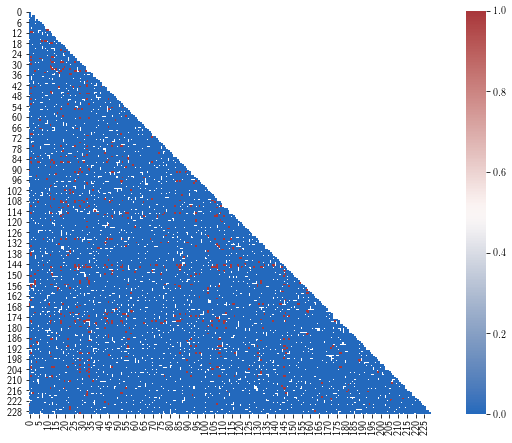

In [34]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(A, mask=~mask_train, square=True, cmap="vlag", ax=ax)

plt.show()

In [35]:
node_name_map = dict(enumerate(G.nodes()))

In [36]:
get_edge_name = lambda e: (node_name_map[e[0]], node_name_map[e[1]])

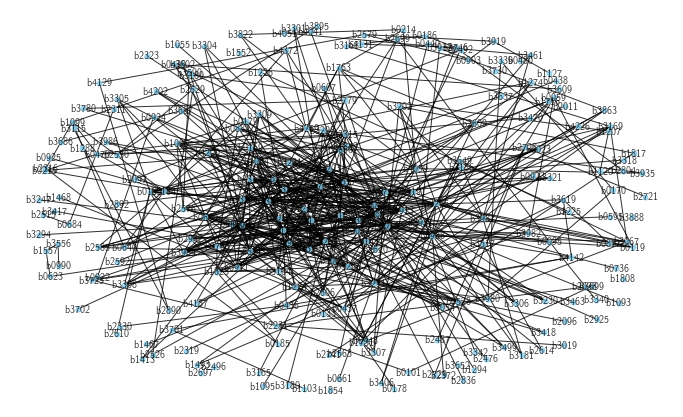

In [37]:
fig, ax = plt.subplots(figsize=golden_size(12))

nx.draw(G, pos=pos, edgelist=list(map(get_edge_name, filter(lambda idx: A[idx], zip(*il_train)))),  
        with_labels=True, font_size=10, node_size=25, alpha=0.8, node_color='skyblue', ax=ax)

plt.show()

### Test labels

In [38]:
mask_test = mask_from_indices_like(il_test, A)
mask_test

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

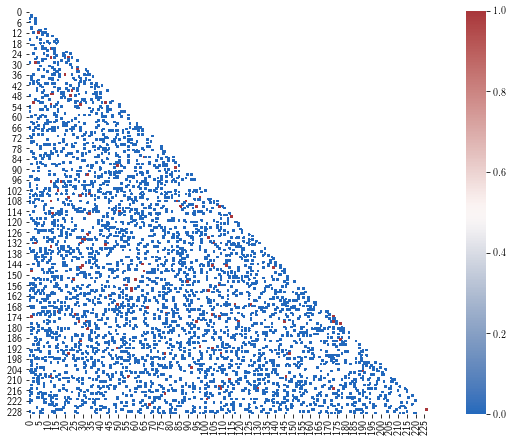

In [39]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(A, mask=~mask_test, square=True, cmap="vlag", ax=ax)

plt.show()

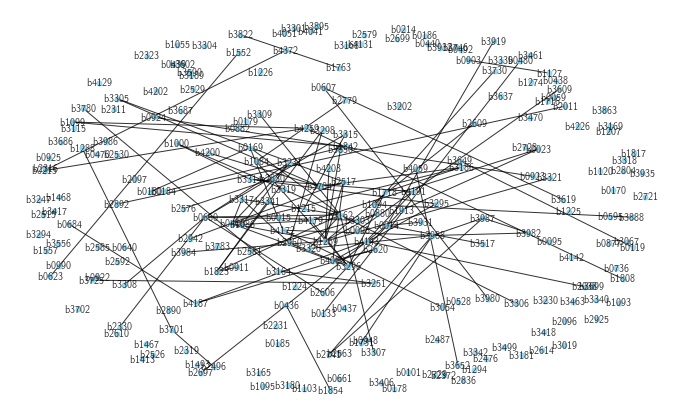

In [40]:
fig, ax = plt.subplots(figsize=golden_size(12))

nx.draw(G, pos=pos, edgelist=list(map(get_edge_name, filter(lambda idx: A[idx], zip(*il_test)))),  
        with_labels=True, font_size=10, node_size=25, alpha=0.8, node_color='skyblue', ax=ax)

plt.show()

### Train-test Partitioned Graph Visualization

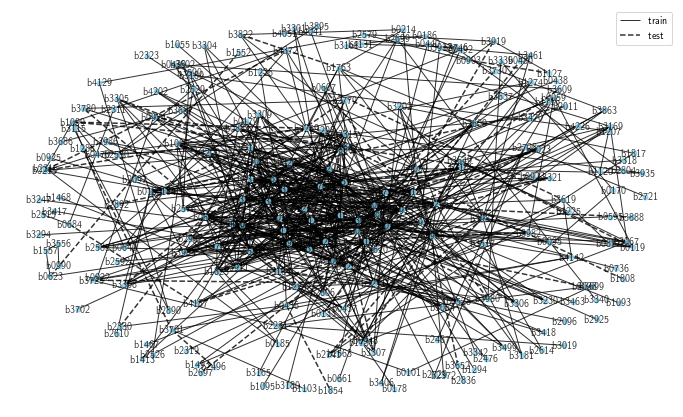

In [41]:
fig, ax = plt.subplots(figsize=golden_size(12))

nx.draw(G, pos=pos, edgelist=[], #list(map(get_edge_name, filter(lambda idx: A[idx], zip(*il_train)))),  
        with_labels=True, font_size=10, node_size=25, alpha=0.8, node_color='skyblue', ax=ax)

nx.draw_networkx_edges(G, pos=pos, edgelist=list(map(get_edge_name, filter(lambda idx: A[idx], zip(*il_train)))),  
                       alpha=0.8, label="train", ax=ax)

nx.draw_networkx_edges(G, pos=pos, edgelist=list(map(get_edge_name, filter(lambda idx: A[idx], zip(*il_test)))),  
                       style="dashed", width=1.5, alpha=0.8, label="test", ax=ax)

ax.legend()

plt.show()

In [42]:
Z = tf.get_variable(name="latent_features", shape=[N, K])
Z

<tf.Variable 'latent_features:0' shape=(230, 3) dtype=float32_ref>

In [43]:
b = tf.get_variable(name="local_bias", shape=[N])
b

<tf.Variable 'local_bias:0' shape=(230,) dtype=float32_ref>

In [44]:
c = tf.get_variable(name="global_bias", shape=[])
c

<tf.Variable 'global_bias:0' shape=() dtype=float32_ref>

In [45]:
bias = b + tf.expand_dims(b, axis=-1) + c
bias

<tf.Tensor 'add_1:0' shape=(230, 230) dtype=float32>

In [46]:
logits = tf.matmul(Z, Z, transpose_b=True) + bias
logits

<tf.Tensor 'add_2:0' shape=(230, 230) dtype=float32>

In [47]:
likelihood = tfp.distributions.Bernoulli(logits=logits)
likelihood

<tfp.distributions.Bernoulli 'Bernoulli/' batch_shape=(230, 230) event_shape=() dtype=int32>

In [48]:
prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(K))
prior

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag/' batch_shape=() event_shape=(3,) dtype=float32>

In [49]:
prior.log_prob(Z)

<tf.Tensor 'MultivariateNormalDiag/log_prob/add:0' shape=(230,) dtype=float32>

In [50]:
nlp = - likelihood.log_prob(A)
nlp

<tf.Tensor 'Neg:0' shape=(230, 230) dtype=float32>

In [51]:
loss = tf.reduce_sum(tf.boolean_mask(nlp, np.int32(mask_train))) + tf.reduce_sum(prior.log_prob(Z))
loss

<tf.Tensor 'add_3:0' shape=() dtype=float32>

In [52]:
A_score = likelihood.probs
A_score

<tf.Tensor 'Bernoulli/probs:0' shape=(230, 230) dtype=float32>

In [53]:
A_pred = likelihood.mode()
A_pred

<tf.Tensor 'Bernoulli/mode/Cast:0' shape=(230, 230) dtype=int32>

In [54]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
train_op = optimizer.minimize(loss)

In [55]:
sess.run(tf.global_variables_initializer())

In [56]:
sess.run(tf.boolean_mask(nlp, np.int32(mask_train))).shape

(22384,)

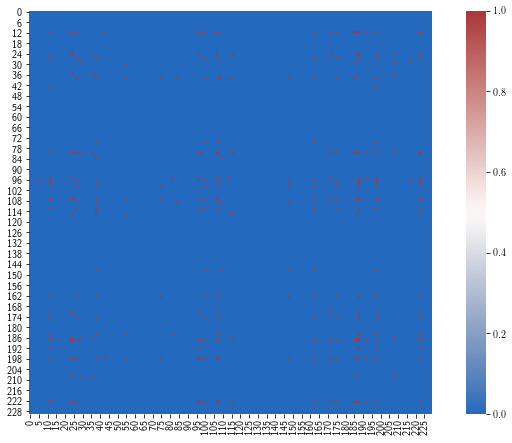

In [57]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(A_pred.eval(), square=True, cmap="vlag", vmin=0.0, vmax=1.0, ax=ax)

plt.show()

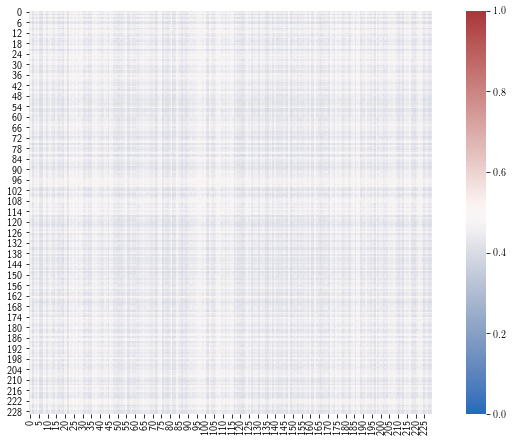

In [58]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(A_score.eval(), square=True, cmap="vlag", vmin=0.0, vmax=1.0, ax=ax)

plt.show()

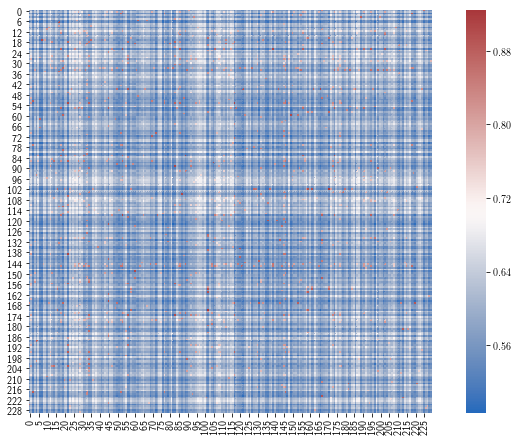

In [59]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(nlp.eval(), square=True, cmap="vlag", ax=ax)

plt.show()

In [60]:
for epoch in range(NUM_EPOCHS):

    sess.run(train_op)

    if not epoch % EVERY_STEPS:

        _loss = sess.run(loss)

        print("epoch = {:04d}, loss = {:04f}".format(epoch, _loss))

epoch = 0000, loss = 12468.929688
epoch = 0100, loss = 2224.819092
epoch = 0200, loss = 1063.762939
epoch = 0300, loss = 654.472778
epoch = 0400, loss = 346.091431
epoch = 0500, loss = -16.746094
epoch = 0600, loss = -548.535889
epoch = 0700, loss = -1344.791992
epoch = 0800, loss = -2334.349609
epoch = 0900, loss = -3523.316162
epoch = 1000, loss = -4823.166016
epoch = 1100, loss = -6212.309082
epoch = 1200, loss = -7692.609863
epoch = 1300, loss = -9265.475586
epoch = 1400, loss = -10934.345703
epoch = 1500, loss = -12702.319336
epoch = 1600, loss = -14576.699219
epoch = 1700, loss = -16563.957031
epoch = 1800, loss = -18654.541016
epoch = 1900, loss = -20840.792969


In [61]:
y_score = A_score.eval()
y_score

array([[0.17, 0.  , 0.  , ..., 0.  , 0.  , 0.02],
       [0.  , 0.94, 0.1 , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.1 , 0.02, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.02, 0.  ],
       [0.02, 0.  , 0.  , ..., 0.  , 0.  , 0.01]], dtype=float32)

In [62]:
y_pred = A_pred.eval()
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [63]:
from sklearn.metrics import (accuracy_score, zero_one_loss, average_precision_score, 
                             precision_recall_curve, roc_auc_score, roc_curve, 
                             classification_report, confusion_matrix)

In [64]:
1 - nx.density(G)

0.9736092652363775

In [65]:
acc = accuracy_score(A[il_test], y_pred[il_test])
acc

0.9721589471019995

In [66]:
ap = average_precision_score(A[il_test], y_score[il_test])
ap

0.29870166404271214

In [67]:
auc = roc_auc_score(A[il_test], y_score[il_test])
auc

0.8519975605366819

### Receiver Operating Characteristic Curve

In [68]:
fpr, tpr, thresholds = roc_curve(A[il_test], y_score[il_test])

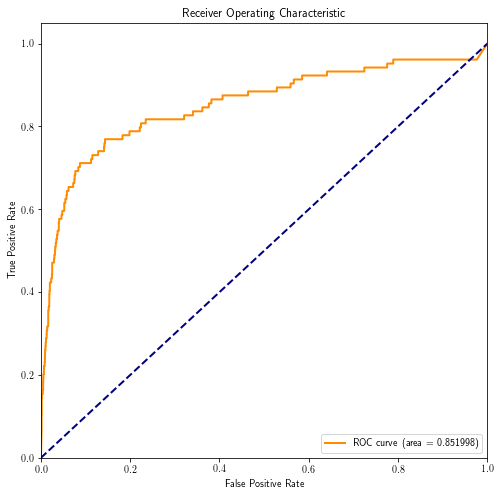

In [69]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:02f})'.format(auc))

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.set_title('Receiver Operating Characteristic')

ax.legend(loc="lower right")

plt.show()

### Precision-Recall Curve

In [70]:
precision, recall, _ = precision_recall_curve(A[il_test], y_score[il_test])

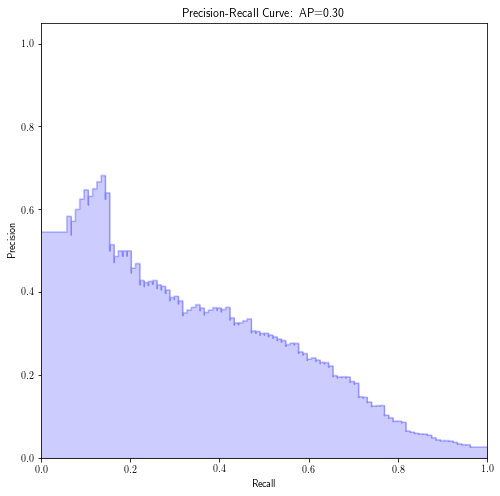

In [71]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.step(recall, precision, color='b', alpha=0.2, where='post')
ax.fill_between(recall, precision, alpha=0.2, color='b', step='post')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

ax.set_title('Precision-Recall Curve: AP={0:0.2f}'.format(ap))

plt.show()

### Confusion Matrix

In [72]:
cm = confusion_matrix(A[il_test], y_pred[il_test])

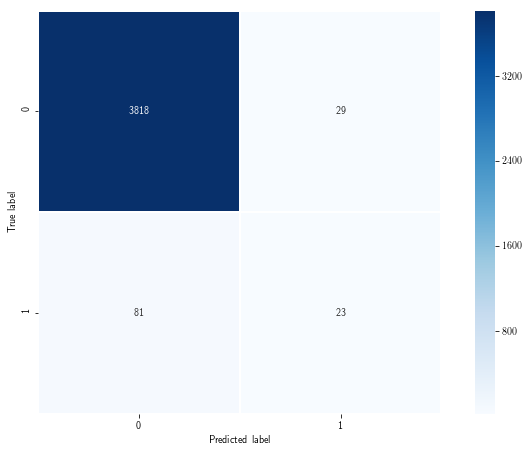

In [73]:
fig, ax = plt.subplots(figsize=golden_size(12))

sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", linewidths=1, 
            square=True, ax=ax)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

plt.show()

In [74]:
print(classification_report(A[il_test], y_pred[il_test]))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3847
         1.0       0.44      0.22      0.29       104

   micro avg       0.97      0.97      0.97      3951
   macro avg       0.71      0.61      0.64      3951
weighted avg       0.97      0.97      0.97      3951

